# EDA on SAE Encoded Dataset

**Goal:** Investigate correlations between SAE latent features and demographic labels (age, gender, race), controlling for potential confounding effects between the labels.


In [33]:
import h5py
import hdf5plugin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Potentially import umap if installed:
import umap

import os
import time

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Configuration

In [34]:
# HDF5_PATH = "../data/processed/sae_encoded_dataset.hdf5" # Relative to notebook location
HDF5_PATH = "../../data/sae_latent_fairface.hdf5"
# Specify the data split to use for analysis
DATA_SPLIT = "training"

# --- Sampling ---
# Set to None to load all data (if memory allows), otherwise specify number of samples
N_SAMPLES = 10000 # Example: Load 10k samples for faster iteration

# --- Analysis ---
# Significance level for corrected p-values
ALPHA = 0.05
# Number of top features to display and visualize
TOP_N_FEATURES = 10

# --- File Checks ---
if not os.path.exists(HDF5_PATH):
    raise FileNotFoundError(f"HDF5 file not found at: {HDF5_PATH}")

print(f"Using HDF5 file: {HDF5_PATH}")
print(f"Analyzing split: {DATA_SPLIT}")
print(f"Loading samples: {'All' if N_SAMPLES is None else N_SAMPLES}")
print(f"Significance level (alpha): {ALPHA}")
print(f"Top N features to report: {TOP_N_FEATURES}")

Using HDF5 file: ../../data/sae_latent_fairface.hdf5
Analyzing split: training
Loading samples: 10000
Significance level (alpha): 0.05
Top N features to report: 10


## 3. Data Loading and Preparation (Plan Section 4.1)

In [35]:
print("Loading data...")
start_time = time.time()

try:
    with h5py.File(HDF5_PATH, 'r') as f:
        if DATA_SPLIT not in f:
            raise KeyError(f"Split '{DATA_SPLIT}' not found in HDF5 file. Available keys: {list(f.keys())}")

        split_group = f[DATA_SPLIT]

        if 'latent_activations' not in split_group or 'labels' not in split_group:
            raise KeyError(f"'latent_activations' or 'labels' group not found in '{DATA_SPLIT}'. Available keys: {list(split_group.keys())}")

        labels_group = split_group['labels']
        required_labels = ['age', 'gender', 'race']
        if not all(label in labels_group for label in required_labels):
            raise KeyError(f"Missing one or more required labels {required_labels} in '{DATA_SPLIT}/labels'. Available keys: {list(labels_group.keys())}")

        # Get total number of samples in the split
        total_samples = split_group['latent_activations'].shape[0]
        d_latent = split_group['latent_activations'].shape[1]
        print(f"Total samples in '{DATA_SPLIT}': {total_samples}")
        print(f"Latent dimension (D_latent): {d_latent}")

        # Determine indices to load
        if N_SAMPLES is None or N_SAMPLES >= total_samples:
            print("Loading all samples.")
            indices = slice(None) # Load everything
            n_loaded = total_samples
        else:
            print(f"Sampling {N_SAMPLES} random samples.")
            indices = np.random.choice(total_samples, N_SAMPLES, replace=False)
            indices.sort() # Load in order for potentially better HDF5 read performance
            n_loaded = N_SAMPLES

        # Load latent activations
        print("Loading latent activations...")
        latents = split_group['latent_activations'][indices, :]
        # Convert to float32 for stability
        latents = latents.astype(np.float32)
        print(f"Latent activations shape: {latents.shape}")

        # Load labels
        print("Loading labels...")
        age = labels_group['age'][indices]
        gender = labels_group['gender'][indices]
        race = labels_group['race'][indices]

        # Create DataFrame
        print("Creating DataFrame...")
        feature_cols = [f'feature_{i}' for i in range(d_latent)]
        df = pd.DataFrame(latents, columns=feature_cols)
        df['age'] = age.flatten()
        df['gender'] = gender.flatten()
        df['race'] = race.flatten()

        # Clear large arrays from memory if sampling
        if N_SAMPLES is not None and N_SAMPLES < total_samples:
             del latents, age, gender, race

except Exception as e:
    print(f"Error loading data: {e}")
    # Depending on the environment, might want to exit or handle differently
    raise

print(f"Data loading and DataFrame creation complete. Shape: {df.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

Loading data...
Total samples in 'training': 11842
Latent dimension (D_latent): 2048
Sampling 10000 random samples.
Loading latent activations...
Latent activations shape: (10000, 2048)
Loading labels...
Creating DataFrame...
Data loading and DataFrame creation complete. Shape: (10000, 2051)
Time taken: 3.70 seconds


### 3.1 Label Inspection

In [36]:
print("Label value counts and descriptions:")
print("\n--- Age ---")
print(df['age'].describe())
print("\nValue Counts (Top 10):")
print(df['age'].value_counts().head(10))

print("\n--- Gender ---")
print(df['gender'].describe())
print("\nValue Counts:")
print(df['gender'].value_counts())

print("\n--- Race ---")
print(df['race'].describe())
print("\nValue Counts:")
print(df['race'].value_counts())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum().max() == 0) # Quick check if any NaNs exist

Label value counts and descriptions:

--- Age ---
count    10000.000000
mean         3.855600
std          2.465392
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          8.000000
Name: age, dtype: float64

Value Counts (Top 10):
age
2    1203
3    1187
4    1183
6    1177
5    1166
1    1162
7    1157
0    1052
8     713
Name: count, dtype: int64

--- Gender ---
count    10000.000000
mean         0.498300
std          0.500022
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

Value Counts:
gender
0    5017
1    4983
Name: count, dtype: int64

--- Race ---
count    10000.000000
mean         3.002300
std          2.004569
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: race, dtype: float64

Value Counts:
race
3    1490
1    1468
6    1457
5    1427
0    1416
2    1380
4    1362
Name: co

### 3.2 Data Preparation for Regression

In [37]:
# Standardize Age
scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['age']])
print("Standardized 'age' into 'age_scaled'.")

# Create Dummy Variables
# Assuming Gender is binary (0/1 or similar). If not, adjust accordingly.
# If Gender=0 is a meaningful category, keep it. If it needs a reference, use drop_first=True.
df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=True) # Assumes 2 categories, drops the first as reference
print(f"Created dummy variables for 'gender'. New columns: {list(df.filter(regex='gender_').columns)}")

# Use drop_first=True to avoid multicollinearity by setting one race category as the reference
df = pd.get_dummies(df, columns=['race'], prefix='race', drop_first=True)
print(f"Created dummy variables for 'race'. New columns: {list(df.filter(regex='race_').columns)}")

# Define predictor columns
predictor_cols = ['age_scaled'] + list(df.filter(regex='gender_').columns) + list(df.filter(regex='race_').columns)
print(f"\nPredictor columns for regression: {predictor_cols}")

# Prepare the predictor matrix (adding a constant for the intercept)
X_design = df[predictor_cols]
X_design = sm.add_constant(X_design, has_constant='add') # Add intercept column

# --- Start Modification ---
# Convert the entire design matrix to float *before* checks and loop
# This converts boolean True/False to 1.0/0.0
print("\nConverting X_design to float type...")
X_design = X_design.astype(float)
# --- End Modification ---


print(f"\nShape of design matrix (X with constant): {X_design.shape}")
print("\nFirst 5 rows of design matrix:")
print(X_design.head())

Standardized 'age' into 'age_scaled'.
Created dummy variables for 'gender'. New columns: ['gender_1']
Created dummy variables for 'race'. New columns: ['race_1', 'race_2', 'race_3', 'race_4', 'race_5', 'race_6']

Predictor columns for regression: ['age_scaled', 'gender_1', 'race_1', 'race_2', 'race_3', 'race_4', 'race_5', 'race_6']

Converting X_design to float type...

Shape of design matrix (X with constant): (10000, 9)

First 5 rows of design matrix:
   const  age_scaled  gender_1  race_1  race_2  race_3  race_4  race_5  race_6
0    1.0   -1.563968       0.0     0.0     0.0     0.0     0.0     0.0     0.0
1    1.0    0.869844       1.0     0.0     0.0     1.0     0.0     0.0     0.0
2    1.0    0.058574       1.0     0.0     0.0     0.0     1.0     0.0     0.0
3    1.0   -1.563968       1.0     0.0     0.0     0.0     0.0     0.0     0.0
4    1.0   -1.158332       0.0     0.0     1.0     0.0     0.0     0.0     0.0


# 4. Controlled Association Analysis (Plan Section 4.2)

We will fit a multiple linear regression model for each latent feature:

$ \text{LatentFeature}_d = \beta_0 + \beta_{age} \cdot \text{Age}_{\text{scaled}} + \sum_{j} \beta_{gender_j} \cdot \text{Gender}_j + \sum_{k} \beta_{race_k} \cdot \text{Race}_k + \epsilon $

We analyze the coefficients ($\beta$) and their p-values to understand the unique association of each demographic variable with the feature, after controlling for the others.



In [38]:
print("--- Debug: Checking X_design before loop ---")
print("X_design dtypes:")
print(X_design.dtypes)
print(f"\nX_design contains NaNs: {X_design.isnull().values.any()}")
print(f"X_design contains Infs: {np.isinf(X_design.values).any()}")
print(f"X_design is finite: {np.isfinite(X_design.values).all()}")
# --- End Debug Diagnostics ---


results = []
feature_cols = [f'feature_{i}' for i in range(d_latent)] # Get column names again

print(f"\nStarting regression analysis for {d_latent} features...")
start_time = time.time()

for i, feature in enumerate(feature_cols):
    if (i + 1) % 1000 == 0:
        print(f"  Processing feature {i+1}/{d_latent}...")

    # Define dependent variable (the current latent feature)
    y = df[feature]

    # --- Start Debug Diagnostics (Inside Loop - First Iteration Only) ---
    if i == 0:
        print("\n--- Debug: Checking y (first feature) ---")
        print(f"y dtype: {y.dtype}")
        print(f"y contains NaNs: {y.isnull().any()}")
        print(f"y contains Infs: {np.isinf(y.values).any()}")
        print(f"y is finite: {np.isfinite(y.values).all()}")
        print("--- End Debug Diagnostics ---")
    # --- End Debug Diagnostics ---


    # Fit OLS model
    try:
        # Explicitly convert to numeric types just before fitting as a potential fix
        # Though understanding the root cause via diagnostics is better
        model = sm.OLS(y.astype(float), X_design.astype(float), missing='drop') # Added astype(float) and missing='drop'
        fit = model.fit()

        # Store results (coefficients, p-values) for each predictor
        for predictor in X_design.columns:
             # Skip the constant intercept term for ranking purposes
             if predictor == 'const':
                 continue

             results.append({
                 'feature_index': i,
                 'feature_name': feature,
                 'predictor': predictor,
                 'coefficient': fit.params[predictor],
                 'p_value': fit.pvalues[predictor],
                 'std_err': fit.bse[predictor],
                 't_stat': fit.tvalues[predictor]
                 # Note: Partial R^2 or effect size calculation might need more work
                 # or specific functions depending on the desired metric.
                 # fit.rsquared gives the overall R^2 for the model on this feature.
             })

    except Exception as e:
        print(f"Error fitting model for feature {feature}: {e}")
        # Handle error, e.g., skip feature or store NaN results

results_df = pd.DataFrame(results)
print(f"\nRegression analysis complete.")
print(f"Time taken: {time.time() - start_time:.2f} seconds")
print(f"\nResults DataFrame shape: {results_df.shape}")
print(results_df.head())

--- Debug: Checking X_design before loop ---
X_design dtypes:
const         float64
age_scaled    float64
gender_1      float64
race_1        float64
race_2        float64
race_3        float64
race_4        float64
race_5        float64
race_6        float64
dtype: object

X_design contains NaNs: False
X_design contains Infs: False
X_design is finite: True

Starting regression analysis for 2048 features...

--- Debug: Checking y (first feature) ---
y dtype: float32
y contains NaNs: False
y contains Infs: False
y is finite: True
--- End Debug Diagnostics ---
  Processing feature 1000/2048...
  Processing feature 2000/2048...

Regression analysis complete.
Time taken: 13.95 seconds

Results DataFrame shape: (16384, 7)
   feature_index feature_name   predictor  coefficient  p_value  std_err  \
0              0    feature_0  age_scaled          0.0      NaN      0.0   
1              0    feature_0    gender_1          0.0      NaN      0.0   
2              0    feature_0      race_1    

### 4.1 Multiple Comparison Correction

Since we performed `D_latent` tests for *each* predictor coefficient, we need to correct the p-values. We will use the Benjamini/Hochberg FDR correction method.

In [39]:
print("Applying FDR correction to p-values...")
# Apply correction separately for each predictor across all features
corrected_results = []
for predictor in results_df['predictor'].unique():
    subset = results_df[results_df['predictor'] == predictor].copy()
    if not subset.empty:
        reject, pvals_corrected, _, _ = multipletests(subset['p_value'], alpha=ALPHA, method='fdr_bh')
        subset['p_value_corrected'] = pvals_corrected
        subset['significant'] = reject
        corrected_results.append(subset)

corrected_results_df = pd.concat(corrected_results)

print("FDR correction complete.")
print(corrected_results_df.head())
print(f"\nTotal significant associations found (alpha={ALPHA}): {corrected_results_df['significant'].sum()}")

Applying FDR correction to p-values...
FDR correction complete.
    feature_index feature_name   predictor  coefficient  p_value  std_err  \
0               0    feature_0  age_scaled          0.0      NaN      0.0   
8               1    feature_1  age_scaled          0.0      NaN      0.0   
16              2    feature_2  age_scaled          0.0      NaN      0.0   
24              3    feature_3  age_scaled          0.0      NaN      0.0   
32              4    feature_4  age_scaled          0.0      NaN      0.0   

    t_stat  p_value_corrected  significant  
0      NaN                NaN        False  
8      NaN                NaN        False  
16     NaN                NaN        False  
24     NaN                NaN        False  
32     NaN                NaN        False  

Total significant associations found (alpha=0.05): 38


### 4.2 Feature Ranking

Rank features based on the significance (corrected p-value) and magnitude of association (coefficient) for each demographic predictor.


In [40]:
# Create rankings for each predictor
rankings = {}

# --- Age Ranking ---
age_results = corrected_results_df[corrected_results_df['predictor'] == 'age_scaled'].sort_values('p_value_corrected')
rankings['age'] = age_results
print(f"\n--- Top {TOP_N_FEATURES} Features Associated with Age (after control) ---")
print(age_results.head(TOP_N_FEATURES)[['feature_name', 'coefficient', 'p_value_corrected', 'significant']])

# --- Gender Ranking ---
# Identify the gender predictor columns (might be just one if binary)
gender_predictors = [p for p in predictor_cols if p.startswith('gender_')]
if gender_predictors:
    gender_results = corrected_results_df[corrected_results_df['predictor'].isin(gender_predictors)].sort_values('p_value_corrected')
    # For multiple gender dummies, might need a combined significance test or focus on one
    rankings['gender'] = gender_results
    print(f"\n--- Top {TOP_N_FEATURES} Features Associated with Gender (dummies: {gender_predictors}) (after control) ---")
    print(gender_results.head(TOP_N_FEATURES)[['feature_name', 'predictor', 'coefficient', 'p_value_corrected', 'significant']])
else:
    print("\n--- No Gender predictors found after dummy creation ---")

# --- Race Ranking ---
# Identify the race predictor columns
race_predictors = [p for p in predictor_cols if p.startswith('race_')]
if race_predictors:
    race_results = corrected_results_df[corrected_results_df['predictor'].isin(race_predictors)]
    # Rank based on p-value, but interpretation needs care (comparison is vs. reference category)
    # Consider magnitude of coefficient as well
    race_results = race_results.sort_values('p_value_corrected')
    rankings['race'] = race_results
    print(f"\n--- Top {TOP_N_FEATURES} Features Associated with Race (dummies: {race_predictors}) (after control) ---")
    # Displaying top hits across *all* race dummy variables combined
    print(race_results.head(TOP_N_FEATURES)[['feature_name', 'predictor', 'coefficient', 'p_value_corrected', 'significant']])
else:
    print("\n--- No Race predictors found after dummy creation ---")


--- Top 10 Features Associated with Age (after control) ---
   feature_name  coefficient  p_value_corrected  significant
0     feature_0          0.0                NaN        False
8     feature_1          0.0                NaN        False
16    feature_2          0.0                NaN        False
24    feature_3          0.0                NaN        False
32    feature_4          0.0                NaN        False
40    feature_5          0.0                NaN        False
48    feature_6          0.0                NaN        False
56    feature_7          0.0                NaN        False
64    feature_8          0.0                NaN        False
72    feature_9          0.0                NaN        False

--- Top 10 Features Associated with Gender (dummies: ['gender_1']) (after control) ---
   feature_name predictor  coefficient  p_value_corrected  significant
1     feature_0  gender_1          0.0                NaN        False
9     feature_1  gender_1          0.0

## 5. Visualization (Plan Section 4.3)

Visualize the relationships for the top-ranked features.

### 5.1 Overall Feature Distributions (Sample)

Plotting distributions for a sample of features...


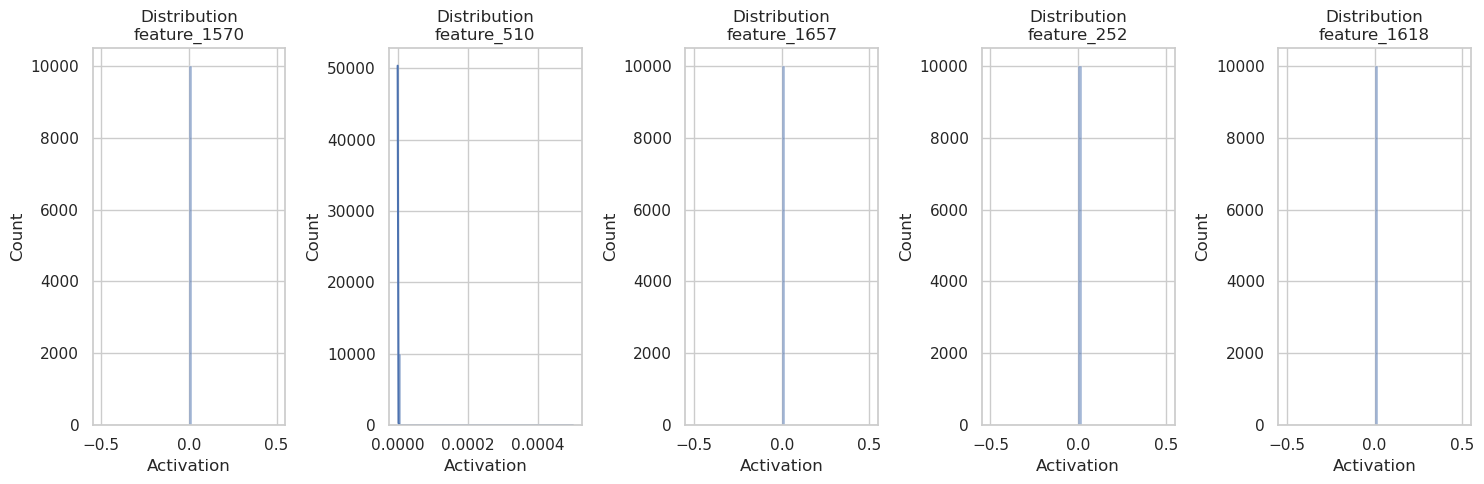

In [41]:
print("Plotting distributions for a sample of features...")
sample_feature_indices = np.random.choice(d_latent, min(d_latent, 5), replace=False)
sample_feature_names = [f'feature_{i}' for i in sample_feature_indices]

plt.figure(figsize=(15, 5))
for i, feature_name in enumerate(sample_feature_names):
    plt.subplot(1, len(sample_feature_names), i + 1)
    sns.histplot(df[feature_name], kde=True, bins=50)
    plt.title(f'Distribution\n{feature_name}')
    plt.xlabel("Activation")
plt.tight_layout()
plt.show()

### 5.2 Top Feature Analysis

Visualize relationships for the top features identified for Age, Gender, and Race.


Plotting distributions for a sample of features...


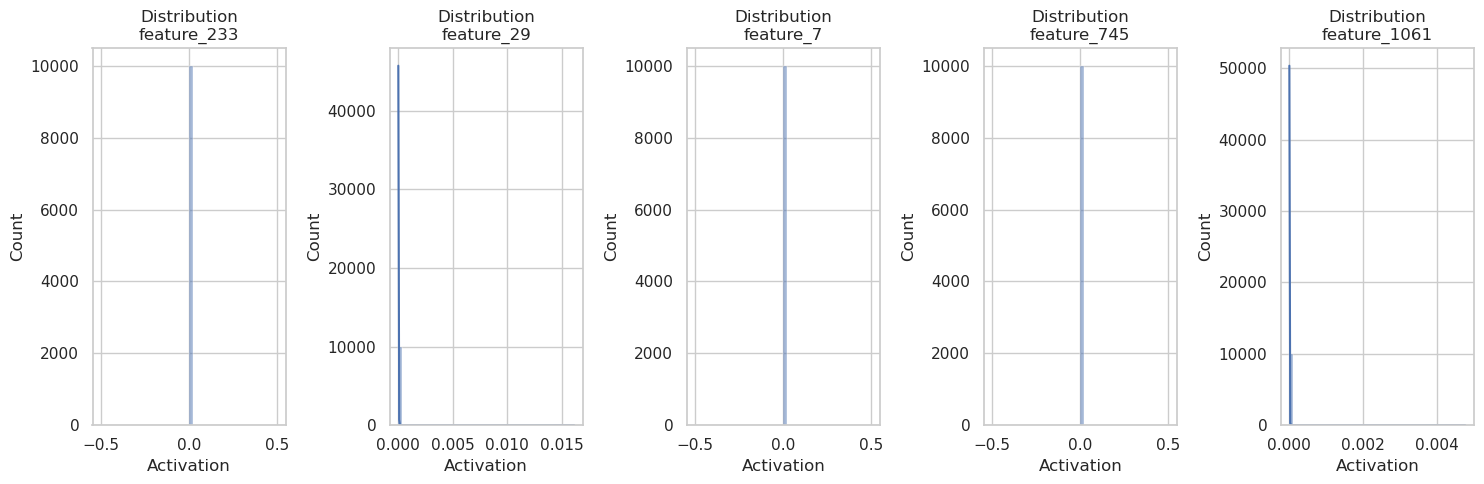


Visualizing top 10 features for Age...


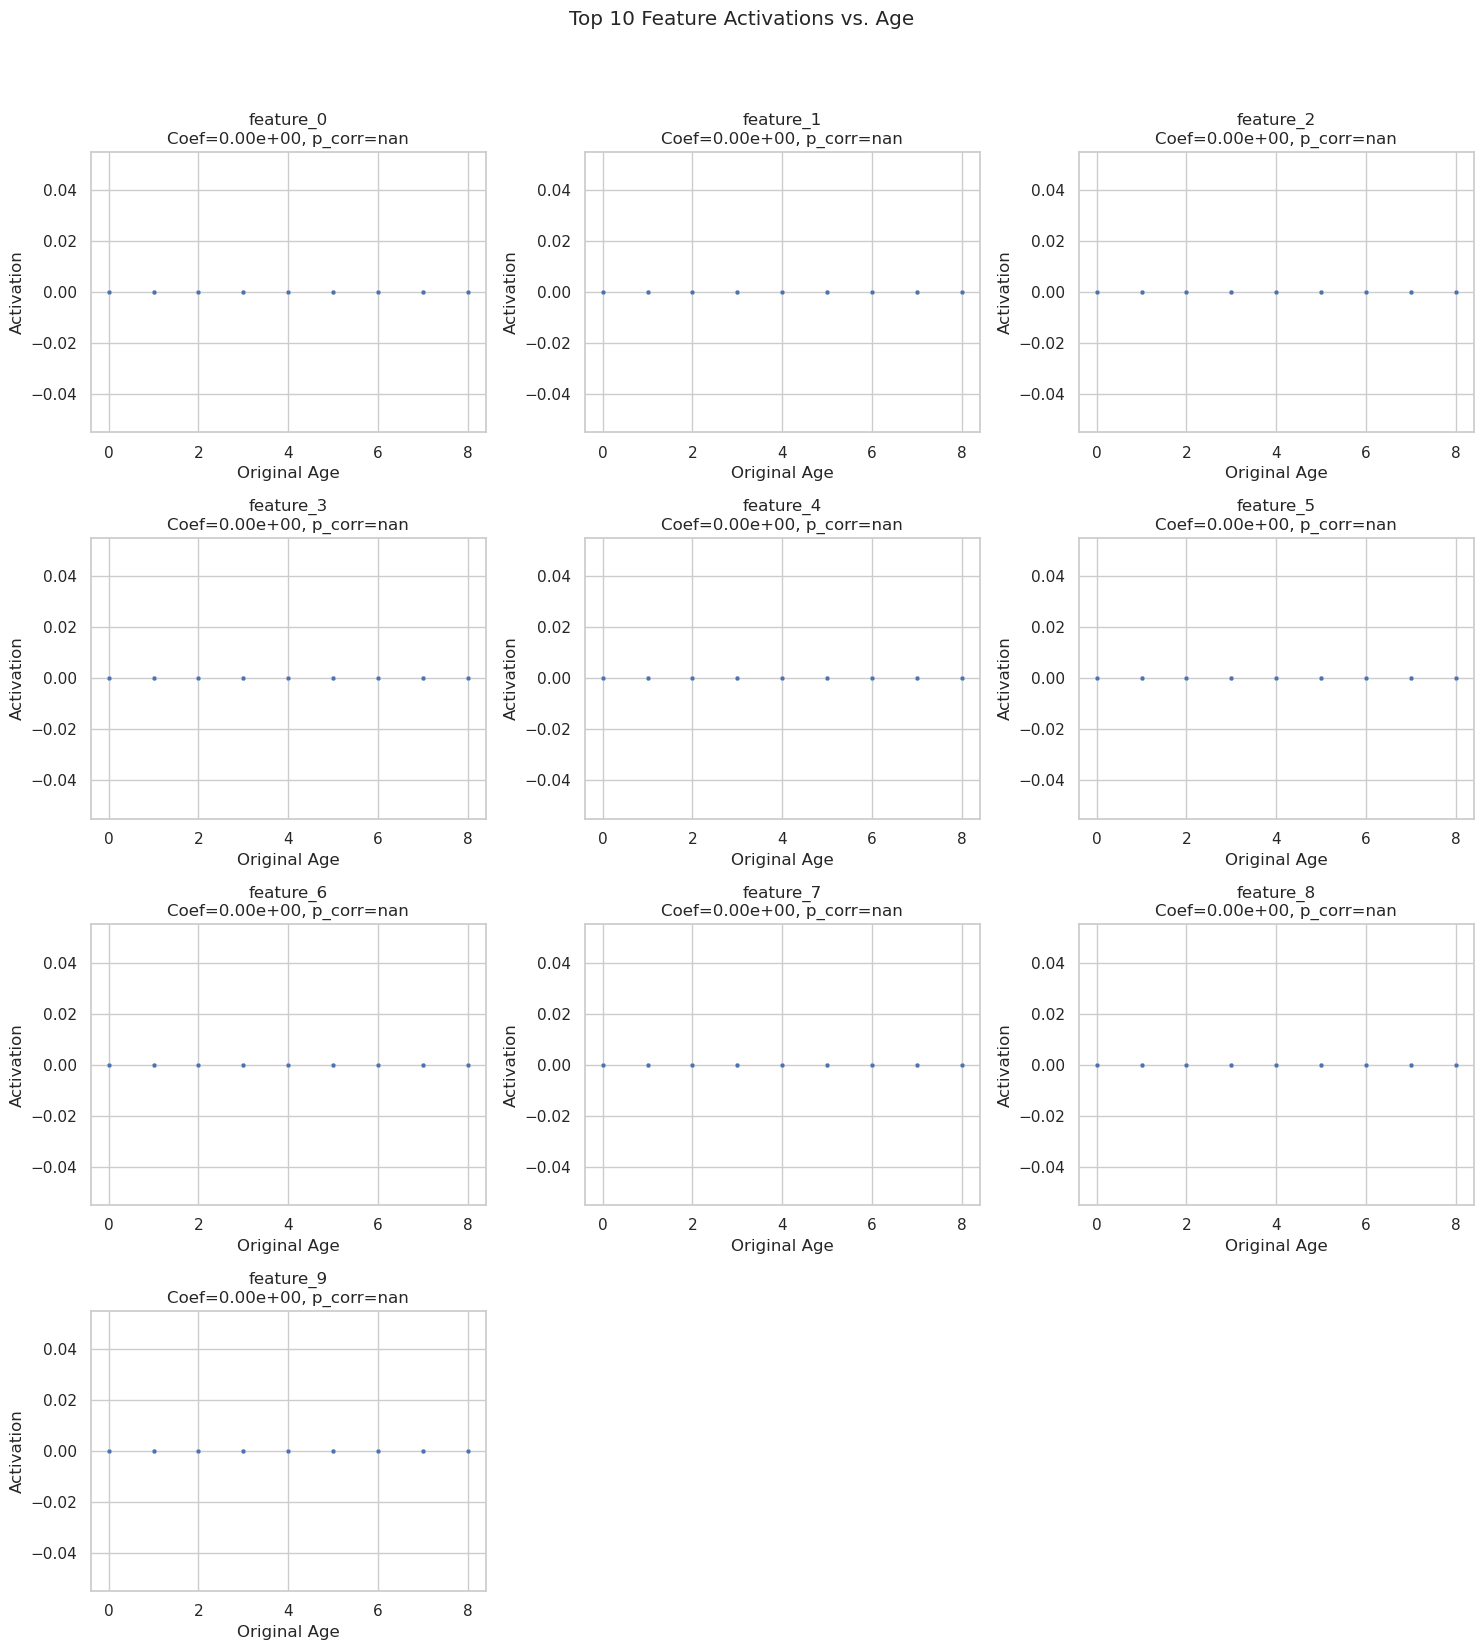


Visualizing top 10 features for Gender...


KeyError: 'gender'

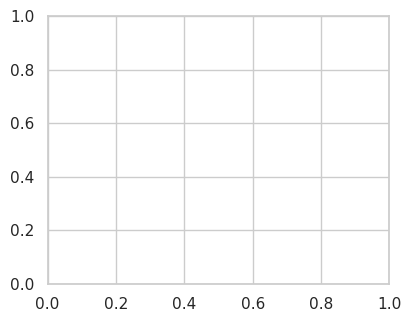

In [43]:
print("Plotting distributions for a sample of features...")
sample_feature_indices = np.random.choice(d_latent, min(d_latent, 5), replace=False)
sample_feature_names = [f'feature_{i}' for i in sample_feature_indices]

plt.figure(figsize=(15, 5))
for i, feature_name in enumerate(sample_feature_names):
    plt.subplot(1, len(sample_feature_names), i + 1)
    sns.histplot(df[feature_name], kde=True, bins=50)
    plt.title(f'Distribution\n{feature_name}')
    plt.xlabel("Activation")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### 5.2 Top Feature Analysis
#
# Visualize relationships for the top features identified for Age, Gender, and Race.

# %%
def plot_top_features(results_sub, demo_var_orig, demo_var_display_name, plot_type='scatter', top_n=5):
    """Helper function to plot top features for a demographic variable."""
    top_features = results_sub.nsmallest(top_n, 'p_value_corrected')['feature_name'].unique()
    if len(top_features) == 0:
        print(f"No significant features found for {demo_var_display_name} to plot.")
        return

    print(f"\nVisualizing top {len(top_features)} features for {demo_var_display_name}...")

    n_plots = len(top_features)
    n_cols = min(n_plots, 3)
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 4))

    for i, feature_name in enumerate(top_features):
        plt.subplot(n_rows, n_cols, i + 1)
        feature_data = df[feature_name]
        demo_data = df[demo_var_orig] # Use original label for plotting

        if plot_type == 'scatter':
            sns.scatterplot(x=demo_data, y=feature_data, alpha=0.3, s=10)
            # Maybe add a regression line (careful with interpretation if relationship is non-linear)
            # sns.regplot(x=demo_data, y=feature_data, scatter_kws={'alpha':0.1, 's':5}, line_kws={'color':'red'})
            plt.xlabel(f"Original {demo_var_display_name}")
            plt.ylabel("Activation")

        elif plot_type == 'box':
            # Ensure demo_data is suitable for boxplot grouping (categorical/few unique values)
             unique_vals = demo_data.nunique()
             if unique_vals > 10:
                 print(f"Warning: High number of unique values ({unique_vals}) for {demo_var_orig}. Boxplot might be cluttered.")
                 # Consider binning or using violin plot instead if appropriate
             sns.boxplot(x=demo_data, y=feature_data)
             plt.xlabel(f"Original {demo_var_display_name} Category")
             plt.ylabel("Activation")

        elif plot_type == 'violin':
              unique_vals = demo_data.nunique()
              if unique_vals > 10:
                  print(f"Warning: High number of unique values ({unique_vals}) for {demo_var_orig}. Violin plot might be cluttered.")
              sns.violinplot(x=demo_data, y=feature_data)
              plt.xlabel(f"Original {demo_var_display_name} Category")
              plt.ylabel("Activation")

        # Add coefficient sign/strength info?
        coef_info = results_sub[results_sub['feature_name'] == feature_name].iloc[0] # Assumes one row per feature per predictor
        coef_val = coef_info['coefficient']
        pval_corr = coef_info['p_value_corrected']
        plt.title(f"{feature_name}\nCoef={coef_val:.2e}, p_corr={pval_corr:.2e}")

    plt.suptitle(f"Top {len(top_features)} Feature Activations vs. {demo_var_display_name}", y=1.03)
    plt.tight_layout()
    plt.show()

# --- Plot for Age ---
if 'age' in rankings:
    plot_top_features(rankings['age'], 'age', 'Age', plot_type='scatter', top_n=TOP_N_FEATURES)

# --- Plot for Gender ---
# Need to select the correct original gender column if dummies were made
original_gender_col = 'gender' # Adjust if original column name was different before get_dummies
if 'gender' in rankings:
     # Use violin or box plot for categorical gender
     plot_top_features(rankings['gender'], original_gender_col, 'Gender', plot_type='violin', top_n=TOP_N_FEATURES)

# --- Plot for Race ---
original_race_col = 'race' # Adjust if needed
if 'race' in rankings:
     # Use violin or box plot for categorical race
     plot_top_features(rankings['race'], original_race_col, 'Race', plot_type='violin', top_n=TOP_N_FEATURES)


## 6. Dimensionality Reduction Visualization (Optional - Plan Section 4.4)
Apply PCA or UMAP to the latent activations and visualize the embeddings colored by demographic labels.


In [46]:
print("Applying PCA for visualization...")
n_components = 2
pca = PCA(n_components=n_components)

# Fit PCA on the loaded latent activations (using the data in the DataFrame)
latent_data_for_pca = df[feature_cols].values
pca_results = pca.fit_transform(latent_data_for_pca)

print(f"Explained variance ratio by PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Explained variance ratio by PC2: {pca.explained_variance_ratio_[1]:.3f}")

pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(n_components)], index=df.index)
vis_df = pd.concat([df[['age', 'gender', 'race']], pca_df], axis=1) # Use original labels for coloring


Applying PCA for visualization...
Explained variance ratio by PC1: 0.532
Explained variance ratio by PC2: 0.270


KeyError: "['gender', 'race'] not in index"

Plotting PCA results colored by demographics...


NameError: name 'vis_df' is not defined

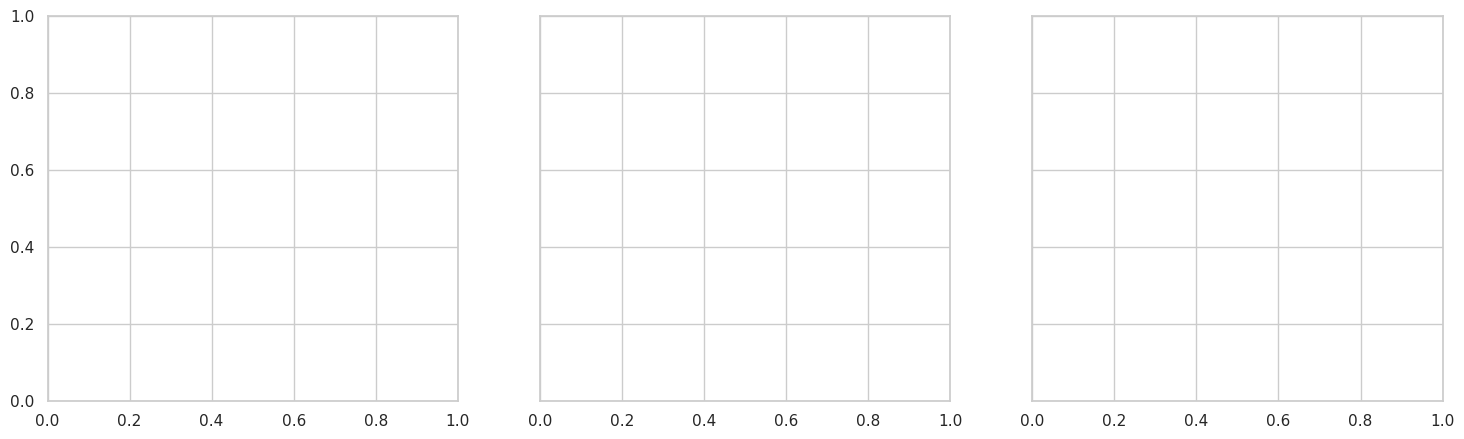

In [45]:
print("Plotting PCA results colored by demographics...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Color by Age
sns.scatterplot(ax=axes[0], data=vis_df, x='PC1', y='PC2', hue='age', palette='viridis', alpha=0.5, s=10, legend='auto')
axes[0].set_title('PCA Colored by Age')
axes[0].legend(title='Age', loc='best')

# Color by Gender (Original)
sns.scatterplot(ax=axes[1], data=vis_df, x='PC1', y='PC2', hue=original_gender_col, palette='colorblind', alpha=0.5, s=10, legend='full')
axes[1].set_title(f'PCA Colored by {original_gender_col}')
axes[1].legend(title=original_gender_col, loc='best')


# Color by Race (Original)
sns.scatterplot(ax=axes[2], data=vis_df, x='PC1', y='PC2', hue=original_race_col, palette='tab10', alpha=0.5, s=10, legend='full')
axes[2].set_title(f'PCA Colored by {original_race_col}')
axes[2].legend(title=original_race_col, loc='best')

plt.suptitle('2D PCA of Latent Activations Colored by Demographic Labels')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()